Importing Necessary Libraries

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.fftpack import fft2
tf.__version__
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping,Callback




Importing the Dataset

In [ ]:
# Load the dataset
image_folder = r"C:\Users\91897\Desktop\CP302\Speckle Images\C_4\Set2\Corner"
csv_file = r"C:\Users\91897\Desktop\CP302\Corner Results\Mean_speckle_contrast_values_Corner.csv"

# Loading Y(Mean Speckle Contrast) values from CSV
df = pd.read_csv(csv_file)
Y_values = df.iloc[1:92,22].values.astype(float)  # Taking Mean  column from row 3 to 92 (90 values)
Y = [f"{value:.4f}" for value in Y_values] #Rounding off numbers to 4 decimal points.
print('Mean Speckle Contrast values: ', Y)
print('Number of Mean Speckle contrast values [Y]: ',len(Y))

Importing the dataset for combined sets

In [81]:
from PIL import Image

# Define the two directories for input images
image_folder1 = r"C:\Users\91897\Desktop\CP302\Speckle Images\C_3\Set1\Center"
image_folder2 = r"C:\Users\91897\Desktop\CP302\Speckle Images\C_3\Set3\Center"
csv_file = r"C:\Users\91897\Desktop\CP302\Center Results\Mean_speckle_contrast_values_Center.csv"

# Define resize dimensions for each folder
resize_folder1 = (1095, 821)  # Dimensions for images in folder1
resize_folder2 = (538, 404)  # Dimensions for images in folder2

# function to load and resize images
def load_and_resize_images(folder, resize_dims):
    resized_images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            image_path = os.path.join(folder, filename)
            img = Image.open(image_path)
            img_resized = img.resize(resize_dims, Image.LANCZOS)
            resized_images.append(img_resized)
    return resized_images

# Load and resize images from both folders with different dimensions
resized_images1 = load_and_resize_images(image_folder1, resize_folder1)
resized_images2 = load_and_resize_images(image_folder2, resize_folder2)

# Combine resized images from both folders
all_resized_images = resized_images1 + resized_images2

print('Total number of images:', len(all_resized_images))

# Load Y (Mean Speckle Contrast) values from CSV file
df = pd.read_csv(csv_file)
Y_values = df.iloc[1:183,9].values.astype(float)  
Y = [f"{value:.4f}" for value in Y_values]

print('Mean Speckle Contrast values:', Y)
print('Number of Mean Speckle contrast values [Y]:', len(Y))



Total number of images: 182
Mean Speckle Contrast values: ['0.4364', '0.4152', '0.4176', '0.4080', '0.4194', '0.4010', '0.3899', '0.4042', '0.3980', '0.3907', '0.4083', '0.4091', '0.4188', '0.3964', '0.3738', '0.3837', '0.3911', '0.3899', '0.4011', '0.3735', '0.3820', '0.3953', '0.3748', '0.3886', '0.3914', '0.3790', '0.3725', '0.3688', '0.3828', '0.3765', '0.3780', '0.3968', '0.3732', '0.3969', '0.3884', '0.3891', '0.3702', '0.3789', '0.3741', '0.3810', '0.3717', '0.4028', '0.3675', '0.3738', '0.4151', '0.3833', '0.4180', '0.3692', '0.3657', '0.4263', '0.3652', '0.4239', '0.3667', '0.4267', '0.3608', '0.4140', '0.3792', '0.4019', '0.3795', '0.3621', '0.3726', '0.3724', '0.3801', '0.3900', '0.3604', '0.3485', '0.3712', '0.3653', '0.3905', '0.3710', '0.3648', '0.3774', '0.3798', '0.3725', '0.3525', '0.3599', '0.3677', '0.3697', '0.3495', '0.3676', '0.3823', '0.3624', '0.3592', '0.3677', '0.3473', '0.3677', '0.3716', '0.3529', '0.3970', '0.3587', '0.4364', '0.4152', '0.4176', '0.4080', '

FFT for combined data

In [82]:
# Function to apply FFT and return magnitude spectrum
def apply_fourier_transform(image):
    f = np.fft.fft2(image)  # Compute the 2D FFT
    fshift = np.fft.fftshift(f)  # Shift zero frequency components to the center
    magnitude_spectrum = np.abs(fshift)  # Get the magnitude
    return magnitude_spectrum

# Prepare input data X
X_values = []  # Arrays storing spatial data for each speckle image sample
resize = (1095, 821)  # Define the desired size for all images (change as needed)

# Loop through all resized images
for img_resized in all_resized_images:
    img_resized = np.array(img_resized.convert("L"))  # Convert to grayscale array
    img_resized = cv2.resize(img_resized, resize)  # Resize again if needed
    img_fft = apply_fourier_transform(img_resized)  # Apply FFT
    X_values.append(img_fft.flatten())  # Flatten the FFT result and store it

# Convert to NumPy array
X_values = np.array(X_values, dtype=np.float32)
print('Spatial domain frequency data for speckle images: ', X_values)
print('Shape of input data X:', X_values.shape)
print('No of Image samples fed:', len(X_values))

# Ensure that X and Y have compatible shapes
if len(X_values) != len(Y):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes and X and Y are matched')

# Initialize an empty list to store motion information features
motion_info = []


Spatial domain frequency data for speckle images:  [[2266.745 2364.541 3824.405 ... 3824.405 2364.541 2266.745]
 [ 627.372 1743.901 2343.769 ... 2343.769 1743.901  627.372]
 [1959.694  470.725 2050.866 ... 2050.866  470.725 1959.694]
 ...
 [ 226.544  262.979  397.907 ...  397.907  262.979  226.544]
 [ 232.803  368.923  144.196 ...  144.196  368.923  232.803]
 [ 349.931  336.004  366.988 ...  366.988  336.004  349.931]]
Shape of input data X: (182, 898995)
No of Image samples fed: 182
Compatible shapes and X and Y are matched


Combined data

In [83]:
# Calculate motion features for each image frame
for i in range(1, len(X_values)):
    diff = X_values[i] - X_values[i - 1]  # Compute the difference between successive frames
    mean_change = np.mean(np.abs(diff))
    std_change = np.std(diff)
    max_change = np.max(np.abs(diff))
    energy_change = np.sum(diff**2)
    motion_info.append([mean_change, std_change, max_change, energy_change])

# Convert the motion information to a NumPy array
motion_info = np.array(motion_info)

# Append a row of zeros for the first frame
motion_info = np.vstack(([0, 0, 0, 0], motion_info))

# Display the shape and content of the motion information
print('Shape of Motion Information:', motion_info.shape)
print('Motion Information Features:', motion_info)


Shape of Motion Information: (182, 4)
Motion Information Features: [[0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [5.843e+03 1.294e+04 7.715e+05 1.505e+14]
 [5.843e+03 1.279e+04 6.264e+05 1.471e+14]
 [5.768e+03 1.278e+04 7.851e+05 1.468e+14]
 [5.748e+03 1.239e+04 4.999e+05 1.380e+14]
 [5.730e+03 1.209e+04 8.133e+05 1.313e+14]
 [5.755e+03 1.224e+04 6.314e+05 1.347e+14]
 [5.759e+03 1.281e+04 7.260e+05 1.475e+14]
 [5.747e+03 1.259e+04 6.550e+05 1.425e+14]
 [5.720e+03 1.203e+04 5.376e+05 1.302e+14]
 [5.782e+03 1.290e+04 6.459e+05 1.497e+14]
 [5.834e+03 1.329e+04 7.077e+05 1.589e+14]
 [5.808e+03 1.309e+04 8.551e+05 1.541e+14]
 [5.772e+03 1.299e+04 7.158e+05 1.516e+14]
 [5.785e+03 1.324e+04 6.929e+05 1.576e+14]
 [5.742e+03 1.250e+04 5.794e+05 1.404e+14]
 [5.702e+03 1.193e+04 5.864e+05 1.279e+14]
 [5.616e+03 1.119e+04 5.852e+05 1.126e+14]
 [5.803e+03 1.326e+04 1.004e+06 1.580e+14]
 [5.827e+03 1.351e+04 8.574e+05 1.641e+14]
 [5.770e+03 1.255e+04 7.419e+05 1.415e+14]
 [5.726e+03 1.242e+04 5.789e+0

Image Preprocessing and FFT

In [ ]:
# Function to apply FFT and return magnitude spectrum
def apply_fourier_transform(image):
    f = np.fft.fft2(image)  # Compute the 2D FFT
    fshift = np.fft.fftshift(f)  # Shift zero frequency components to the center
    magnitude_spectrum = np.abs(fshift)  # Get the magnitude
    return magnitude_spectrum

# Prepare input data X
X_values = []  # Arrays storing spatial data for each speckle image sample
resize = (924,689)  # Define the desired size for all images (change as needed)

# Loop through the images in the specified folder
for image_file in sorted(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    
    if img is not None:
        img_resized = cv2.resize(img, resize)
        img_fft = apply_fourier_transform(img_resized)  # Apply FFT
        X_values.append(img_fft.flatten())  # Flatten the FFT result and store it
    
# Convert to NumPy array
X_values = np.array(X_values,dtype=np.float32)
print('Spatial domain frequency data for speckle images: ',X_values)
print('Shape of input data X:', X_values.shape)
print('No of Image samples fed:',len(X_values))

# Ensure that X and Y have compatible shapes
if len(X_values) != len(Y_values):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes and X and Y are matched')              

Motion Information

In [ ]:
# Initialize an empty list to store motion information features
motion_info = []

# Calculate motion features for each image frame
for i in range(1, len(X_values)):
    # Compute the difference between successive frames
    diff = X_values[i] - X_values[i - 1]
    
    # Calculate motion features
    mean_change = np.mean(np.abs(diff))  # Mean absolute change
    std_change = np.std(diff)  # Standard deviation of the change
    max_change = np.max(np.abs(diff))  # Maximum absolute change
    energy_change = np.sum(diff**2)  # Energy of the change

    # Append the features to the motion_info list
    motion_info.append([mean_change, std_change, max_change, energy_change])

# Convert the motion information to a NumPy array
motion_info = np.array(motion_info)

# Since the first image does not have a preceding frame to compare, we can append zeros or mean values
# Append a row of zeros for the first frame
motion_info = np.vstack(([0, 0, 0, 0], motion_info))

# Display the shape and content of the motion information
print('Shape of Motion Information:', motion_info.shape)
print('Motion Information Features:', motion_info)


Data preprocessing

In [84]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Convert Y from a list of strings to a NumPy array of floats
Y = np.array(Y_values, dtype=np.float32)

# Ensure that X and Y have compatible shapes
if len(motion_info) != len(Y):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes and X and Y are matched')

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(motion_info)


# Splitting data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of y_test:',y_test.shape)



Compatible shapes and X and Y are matched
Shape of X_train: (145, 4)
Shape of y_train: (145,)
Shape of X_test: (37, 4)
Shape of y_test: (37,)


ANN with Hyperparameter tuning with GridsearchCV

In [85]:
class R2ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.r2_train = []
        self.r2_val = []
    
    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.model.validation_data[0])
        y_val_pred = self.model.predict(self.X_val)
        
        r2_train = r2_score(self.model.validation_data[1], y_train_pred)
        r2_val = r2_score(self.y_val, y_val_pred)
        
        self.r2_train.append(r2_train)
        self.r2_val.append(r2_val)
        print(f"Epoch {epoch+1}: R2 Train={r2_train:.3f}, R2 Val={r2_val:.3f}")

# Define the ANN model
def create_model(dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))  # Change as per your input shape
    model.add(Dropout(rate=dropout_rate)) 
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='linear'))  # Assuming regression task
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrapping the model with KerasRegressor
model = KerasRegressor(model=create_model, verbose=0,dropout_rate=0.0)

# Hyperparameter grid for tuning
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.0, 0.2, 0.4],
    'epochs': [50,100],
    'batch_size': [16, 32]
}

In [100]:
from keras.layers import Dense, Dropout
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
r2_callback = R2ScoreCallback(X_test, y_test)

# Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3,n_jobs=-1)
grid_result = grid.fit(X_train, y_train, callbacks=[early_stopping, r2_callback], validation_split=0.2)

# Best model from Grid Search
best_model = grid_result.best_estimator_

C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimal hyperparameters

In [101]:
best_params = grid_result.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'batch_size': 32, 'dropout_rate': 0.0, 'epochs': 50, 'optimizer': 'rmsprop'}


Predictions on the Test set

In [102]:
y_pred = best_model.predict(X_test)
np.set_printoptions(precision=3)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))


[[0.387 0.373]
 [0.382 0.367]
 [0.383 0.36 ]
 [0.381 0.398]
 [0.383 0.379]
 [0.394 0.384]
 [0.384 0.391]
 [0.385 0.39 ]
 [0.381 0.379]
 [0.384 0.39 ]
 [0.392 0.401]
 [0.374 0.365]
 [0.383 0.371]
 [0.374 0.395]
 [0.387 0.383]
 [0.393 0.391]
 [0.39  0.424]
 [0.391 0.379]
 [0.375 0.404]
 [0.364 0.379]
 [0.379 0.347]
 [0.39  0.373]
 [0.384 0.361]
 [0.387 0.378]
 [0.395 0.391]
 [0.391 0.397]
 [0.391 0.373]
 [0.387 0.401]
 [0.368 0.36 ]
 [0.392 0.427]
 [0.391 0.359]
 [0.336 0.414]
 [0.359 0.436]
 [0.385 0.359]
 [0.385 0.371]
 [0.385 0.377]
 [0.389 0.377]]


Performance metrics

In [103]:
from sklearn.metrics import mean_absolute_error
print('R2-score (test set): {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE(test set): ',mean_squared_error(y_test,y_pred))
print('MAE(test set): ',mean_absolute_error(y_test,y_pred))


R2-score (test set): -0.552
MSE(test set):  0.0006123376
MAE(test set):  0.01801415


Plotting results

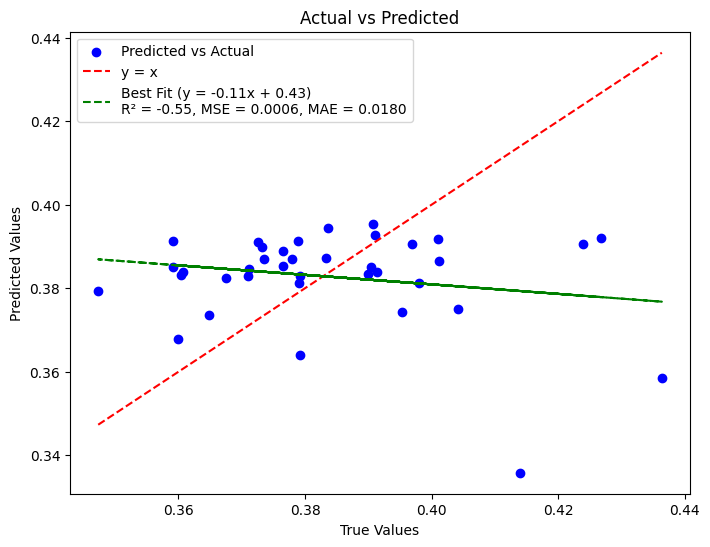

In [104]:
save_dir = r"C:\Users\91897\Desktop\CP302\ML Results\Combined results\ANN+GridsearchCV"
os.makedirs(save_dir, exist_ok=True)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Predicted vs Actual',color = 'blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y = x') #y=x line


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Best-fit line according to the plots(Regression)
slope, intercept = np.polyfit(y_test.flatten(), y_pred.flatten(), 1)
best_fit_line = slope * y_test + intercept

plt.plot(y_test, best_fit_line, 'g--', 
         label=f'Best Fit (y = {slope:.2f}x + {intercept:.2f})\nR² = {r2:.2f}, MSE = {mse:.4f}, MAE = {mae:.4f}')
plt.xlabel('True Values')
#plt.ylim(0.25,0.5)
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig(os.path.join(save_dir, 'ActvsPred_C3_center.png'))
plt.show()


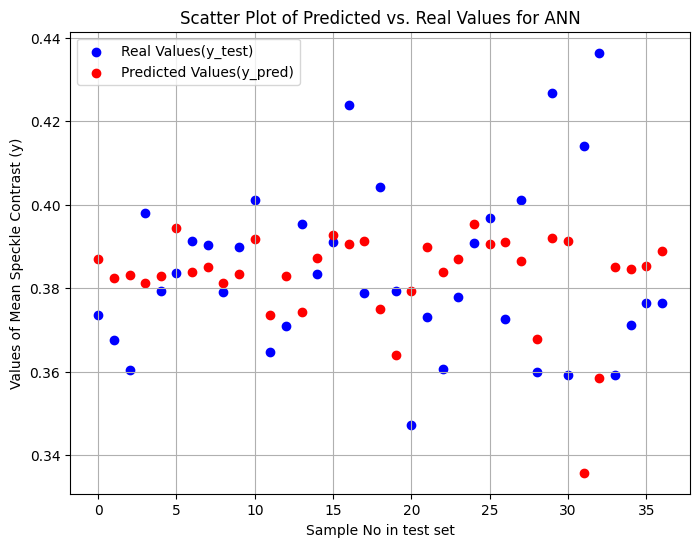

In [105]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Real Values(y_test)')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values(y_pred)')
plt.title('Scatter Plot of Predicted vs. Real Values for ANN')
plt.ylabel('Values of Mean Speckle Contrast (y)')
plt.xlabel('Sample No in test set')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'scatterplot_C3_center.png'))
plt.show()
